In [ ]:
# -*- coding: utf-8 -*-

## "Detection of Accounting Anomalies in the Latent Space using Adversarial Autoencoder Neural Networks"


The content of this lab notebook was jointly developed by Marco Schreyer and Timur Sattarov as part of the 2nd KDD'19 Workshop on "Anomaly Detection in Finance". Further details on the workshop can be found via the workshop <a href="https://sites.google.com/view/kdd-adf-2019">homepage</a>.

Please don't hesitate to contact us in case of any questions via <a href="mailto:marco.schreyer@unisg.ch">marco.schreyer@unisg.ch</a> and <a href="mailto:timur.sattarov@gmail.com">timur.sattarov@gmail.com</a>.

### 1.1 Python Libraries Import

In [1]:
# importing python utility libraries
import os, sys, random, io, urllib
from datetime import datetime

# importing pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display

### 1.2 CUDNN and GPU Verification

To determine if CDNN is available on the server let's execute the cell below to display information about the available CUDNN version:

In [2]:
# print CUDNN backend version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.cudnn.version()))

[LOG 20220508-13:26:46] The CUDNN backend version: None


Also, let's display information about the potential GPUs running on the server:

In [3]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


If CUDNN and GPU's are available let's still specify if we want to use both:

In [4]:
USE_CUDA = True

### 1.3 Python and PyTorch Verification

Let's execute the cell below to display information about the Python and PyTorch version running on the server:

In [5]:
# print current Python version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20220508-13:27:16] The Python version: 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]


In [6]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20220508-13:27:18] The PyTorch version: 1.10.0


### 1.4 Random Seed Initialization

Finally, let' set the seeds of random elements in the code e.g. the initialization of the network parameters to guarantee deterministic computation and results:

In [7]:
# init deterministic seed
seed_value = 1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

### 1.5 Folder Structure Initialization

Create notebook structure to store the data as well as the trained models:

In [8]:
if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

## 2. Financial Fraud Detection Dataset

In this section, we will conduct a descriptive analysis of the financial dataset. Furthermore, we will apply some necessary pre-processing steps to train a deep neural network. The dataset is based on a derivation of the **"Synthetic Financial Dataset For Fraud Detection"** by Lopez-Rojas [6] available via the Kaggle predictive modelling and analytics competitions platform that can be obtained using the following link: https://www.kaggle.com/ntnu-testimon/paysim1.

In [9]:
# load the synthetic ERP dataset
#ori_dataset = pd.read_csv('./data/fraud_dataset_v2.csv')

# load the synthetic ERP dataset
url = 'https://raw.githubusercontent.com/GitiHubi/deepAI/master/data/fraud_dataset_v2.csv'
ori_dataset = pd.read_csv(url)

Let's now inspect the dataset dimensions in terms of the number of journal entries and number of attributes contained:

In [10]:
# inspect the dataset dimensions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20220508-13:28:38] Transactional dataset of 533009 rows and 10 columns loaded


### 2.1 Initial Data and Attribute Assessment

We augmented the dataset and renamed the attributes to appear more similar to a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module. 

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the general ledger account key,
>- `DMBTR`: the amount in local currency,
>- `WRBTR`: the amount in document currency.

Let's also have a closer look into the top 10 rows of the dataset:

In [11]:
# inspect top rows of the ERP dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


You may also have noticed the attribute `label` in the data. We will use this field throughout the lab to evaluate the quality of our trained models. The field describes the true nature of each individual transaction of either being a **regular** transaction (denoted by `regular`) or an **anomaly** (denoted by `global` and `local`). Let's have closer look into the distribution of the regular vs. anomalous transactions in the dataset:

In [12]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

Ok, the statistic reveals that, similar to real world scenarios, we are facing a highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of **100 (0.018%)** anomalous transactions. While the 100 anomalous entries encompass **70 (0.013%)** "global" anomalies and **30 (0.005%)** "local" anomalies as introduced in section 1.2.

In [13]:
# remove the "ground-truth" label information for the following steps of the lab
label = ori_dataset.pop('label')

### 2.2 Pre-Processing of Categorical Transaction Attributes

From the initial data assessment above we can observe that the majority of attributes recorded in AIS- and ERP-systems contain categorical (discrete) attribute values, e.g. the posting date, the general-ledger account, the posting type, the currency. Let's visually inspect the distribution of two of the dataset attributes provided, namely (1) the posting key (technically denoted by `BSCHL`) as well as (2) the general ledger account (technically denoted by `HKONT`):

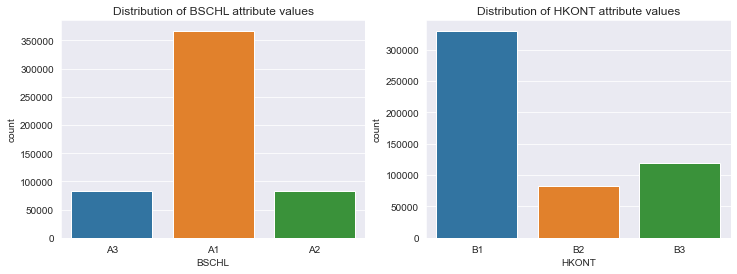

In [14]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of HKONT attribute values');

Unfortunately, neural networks are in general not designed to be trained directly on categorical data and require the attributes to be trained on to be numeric. One simple way to meet this requirement is by applying a technique referred to as "one-hot" encoding. Using this encoding technique, we will derive a numerical representation of each of the categorical attribute values. One-hot encoding creates new binary columns for each categorical attribute value present in the original data.

Let's work through a brief example: The categorical attribute “Receiver” below contains the names "John", "Timur" and "Marco". We "one-hot" encode the names by creating a separate binary column for each possible name value observable in the "Receiver" column. Now, we encode for each transaction that contains the value "John" in the "Receiver" column this observation with 1.0 in the newly created "John" column and 0.0 in all other created name columns.

<img align="middle" style="max-width: 600px; height: auto" src="https://github.com/GitiHubi/deepAD/blob/master/images/encoding.png?raw=1">

Using this technique will "one-hot" encode the 6 categorical attributes in the original transactional dataset to obtain a binary ("one-hot" encoded) representation of each attribute. This can be achieved using the get_dummies() function available in the Pandas data science library:

In [15]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

Finally, let's inspect the encoding of 10 sample transactions to see if we have been successfull:

In [16]:
# inspect encoded sample transactions
ori_dataset_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.2 Pre-Processing of Numerical Transaction Attributes

Let's now inspect the distributions of the two numerical attributes contained in the transactional dataset namely, the (1) local currency amount DMBTR and the (2) document currency amount WRBTR:

/Users/dennisblaufuss/opt/anaconda3/envs/Python3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/dennisblaufuss/opt/anaconda3/envs/Python3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'density')

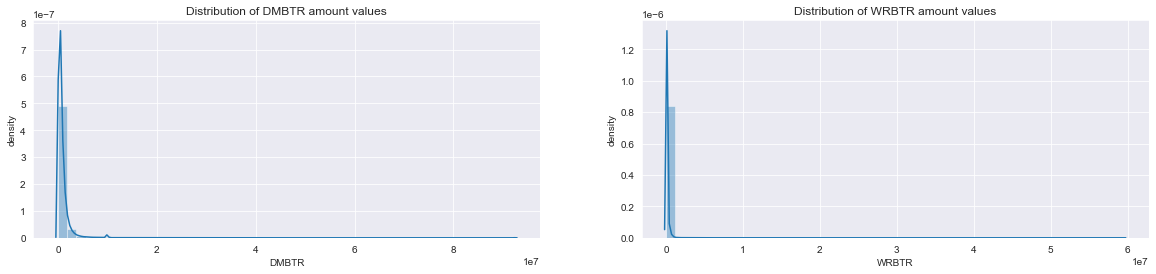

In [17]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density')

As expected, it can be observed, that for both attributes the distributions of amount values are skewed and encompass a heavy tailed distribution. In order to faster approach a potential global minimum it is good practice to scale and normalize numerical input values prior to network training. Therefore, we first log-scale both variables and second min-max normalize the scaled amounts to the interval [0, 1].

In [18]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-4
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

Let's now visualize the log-scaled and min-max normalized distributions of both attributes:

/Users/dennisblaufuss/opt/anaconda3/envs/Python3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/dennisblaufuss/opt/anaconda3/envs/Python3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'density')

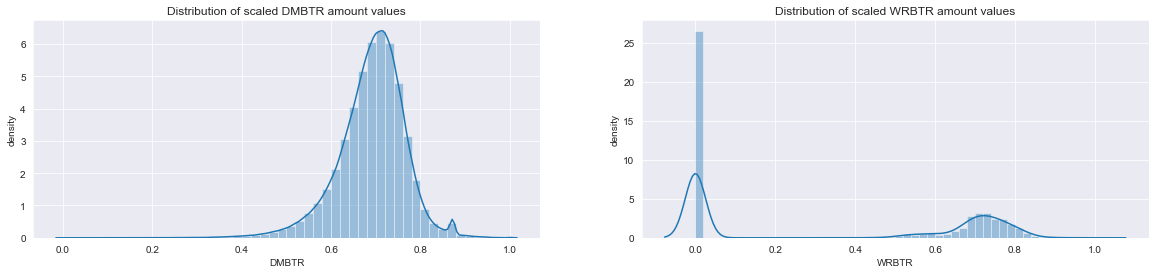

In [19]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset_numeric_attr['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of scaled DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset_numeric_attr['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of scaled WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density')

Ok, let's now visually investigate the scaled distributions of both attributes in terms of the distinct anomaly classes contained in the population of journal entries:

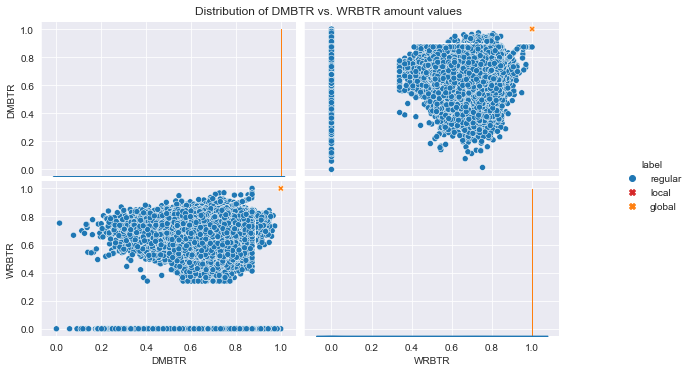

In [20]:
# append 'label' attribute 
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label', palette={'local': 'C3', 'global': 'C1', 'regular': 'C0'}, markers=['o', 'X', 'X'])

# set figure title
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values', y=1.02)

# set figure size
g.fig.set_size_inches(10, 5)

Ok, as anticipated the numeric attribute values of the "global" anomalies (orange) fall outside the range of the regular amount distributions due to their unusual high amount values. In contrast, the numeric attribute values of the "local" anomalies (red) are much more commingled within the regular transaction amounts.
As DMBTR attribute contains a number of extreme values we might want to visulalize its distribution by omitting those set of extreme values.

### 2.3 Merge Categorical and Numerical Transaction Attributes

Finally, we merge both pre-processed numerical and categorical attributes into a single dataset that we will use for training our deep autoencoder neural network (explained an implemented in the following section 4.):

In [21]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

Now, let's again have a look at the dimensionality of the dataset after we applied the distinct pre-processing steps to the attributes:

In [22]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 618)

Ok, upon completion of all the pre-processing steps (incl. the exercises) we should end up with an encoded dataset consisting of a total number of 533,009 records (rows) and **618 encoded attributes** (columns). Let's keep the number number of columns in mind since it will define the dimensionality of the input- and output-layer of our deep autoencoder network which we will now implement in the following section.

## 3. Adversarial Autoencoder Neural Network

The Adversarial Autoencoder Neural Network (AAE) architecture, as illustrated in the figure below, extends the concept
of Autoencoder Neural Networks (AE) by imposing an arbitrary prior on the AEs latent space using a GAN training setup. This is achieved by training the AAE jointly in two phases (1) a reconstruction phase as well as (2) an adversarial regularization phase.

In the reconstruction phase, the AAEs encoder network $q_{\theta}(z|x)$ is trained to learn an aggregated posterior distribution $q(z)$ of the journal entries $X$ over the latent code vector $Z$. Thereby, the learned posterior distribution corresponds to a compressed representation of the journal entry characteristics. Similarly to AENs, the decoder
network $p_{\theta}(\hat{x}|z)$ of the AAE utilizes the learned latent code vector representations $Z$ to reconstruct the journal entries $\hat{X}$ as faithfully as possible to minimize the AAEs reconstruction error.

In the regularization phase, an adversarial training setup is applied were the encoder network $q_{\theta}(z|x)$ of the AAE functions as the generator network. In addition, a discriminator network $d_{\theta}(z)$ is attached on top of the learned latent code vector $Z$. Similarly to GANs, the discriminator network of the AAE is trained to distinguish samples of an imposed prior distribution $p(z)$ onto $Z$ from the learned aggregated posterior distribution $q(z)$. In contrast, the encoder network is trained to learn a posterior distribution $p(z) ≈ q(z)$ that fools the discriminator network into thinking that the samples drawn from $q(z)$ originate from the imposed prior distribution $p(z)$.

<img align="middle" style="max-width: 830px; height: auto" src="https://github.com/GitiHubi/deepAD/blob/master/images/autoencoder_2.png?raw=1">

### 3.1 AAE Implementation - Encoder / Generator Network $q_{\theta}(z|x)$

Now, let's start implementing an AAE by first implementing the encoder-generator network $q_{\theta}(z|x)$ using PyTorch. For the encoder-generator, we aim to implement a network consisting of **five fully-connected layers**. Furthermore, the encoder-generator is specified by the following number of neurons per layer: "618-256-64-16-4-2". Meaning the first layer consists of 618 neurons (specified by the dimensionality of our input data), the second layer of 256 neurons and the subsequent layers of 64, 16, 4 and 2 neurons respectively.

Some elements of the encoder network code below should be given particular attention:

>- `self.encoder_Lx`: defines the linear transformation of the layer applied to the incoming input: $Wx + b$.
>- `nn.init.xavier_uniform`: inits the layer weights using a uniform distribution according to [9].
>- `nn.init.constant`: inits the layer bias with a constant value of 0.0. 
>- `self.encoder_Rx`: defines the non-linear transformation of the layer: $\sigma(\cdot)$.

We use **"Leaky ReLUs"** as introduced by Xu et al. in [7] to avoid "dying" non-linearities and to speed up training convergence. Leaky ReLUs allow a small gradient even when a particular neuron is not active.

In [23]:
# define encoder class
class Encoder(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size):

        # call super class constructor
        super(Encoder, self).__init__()

        # specify first layer - in 618, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 64
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 64, out 16
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 16, out 4
        self.map_L4 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fifth layer - in 4, out 2
        self.map_L5 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_R5 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_R5(self.map_L5(x))

        # return result
        return x

Now, we are ready to instantiate the encoder-generator model to be trained on the CPU or to be trained on any of the available GPUs (if CUDNN is available and `USE_CUDA` is set to `True`) by execution of the following cell:

In [24]:
# init training network classes / architectures
encoder_train = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder_train.cuda()

Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [25]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder-generator architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20220508-13:30:52] encoder-generator architecture:

Encoder(
  (map_L1): Linear(in_features=618, out_features=256, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=256, out_features=64, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=64, out_features=16, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=16, out_features=4, bias=True)
  (map_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L5): Linear(in_features=4, out_features=2, bias=True)
  (map_R5): LeakyReLU(negative_slope=0.4, inplace=True)
)



Looks, great? Excellent!

### 3.2 AAE Implementation - Decoder Network $p_{\theta}(x|z)$

Let's continue the AAE by implementing the corresponding decoder network. The decoder also consists of five fully-connected layers. Furthermore, the decoder network is intended to **symmetrically mirror** the encoder networks architecture by a layer wise inversion "2-4-16-64-256" of the encoder network layers.

In [26]:
# define decoder class
class Decoder(nn.Module):

    # define class constructor
    def __init__(self, output_size, hidden_size):

        # call super class constructor
        super(Decoder, self).__init__()

        # specify first layer - in 2, out 4
        self.map_L1 = nn.Linear(hidden_size[0], hidden_size[1], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 4, out 16
        self.map_L2 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 64
        self.map_L3 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 64, out 256
        self.map_L4 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fifth layer - in 256, out 618
        self.map_L5 = nn.Linear(hidden_size[4], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_S5 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_S5(self.map_L5(x))

        # return result
        return x

Let's also instantiate the decoder model for CPU or GPU training and convince ourselves that it was successfully initialized by printing and reviewing its architecture by execution of the following cell:

In [27]:
# init training network classes / architectures
decoder_train = Decoder(output_size=ori_subset_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    decoder_train = decoder_train.cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20220508-13:31:19] decoder architecture:

Decoder(
  (map_L1): Linear(in_features=2, out_features=4, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=4, out_features=16, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=16, out_features=64, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=64, out_features=256, bias=True)
  (map_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L5): Linear(in_features=256, out_features=618, bias=True)
  (map_S5): Sigmoid()
)



### 3.3 AAE Implementation - Discriminator Network $d_{\theta}(z)$

Let's, now as a final step, complete the AAE implementation by implementing the discriminator network $d_{\theta}(z)$. The discriminator also consists of five fully-connected layers. Furthermore, the discriminator is specified by the following number of neurons per layer: "256-16-4-2".

In [28]:
# define discriminator class
class Discriminator(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size, output_size):

        # call super class constructor
        super(Discriminator, self).__init__()

        # specify first layer - in 2, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 16
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 4
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fourth layer - in 4, out 2
        self.map_L4 = nn.Linear(hidden_size[2], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_S4 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_S4(self.map_L4(x))

        # return result
        return x

Let's also instantiate the discriminator model for CPU or GPU training and convince ourselves that it was successfully initialized by printing and reviewing its architecture by execution of the following cell:

In [29]:
# init training network classes / architectures
discriminator_train = Discriminator(input_size=2, hidden_size=[256, 16, 4, 2], output_size=1)

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    discriminator_train = discriminator_train.cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] discriminator architecture:\n\n{}\n'.format(now, discriminator_train))

[LOG 20220508-13:31:23] discriminator architecture:

Discriminator(
  (map_L1): Linear(in_features=2, out_features=256, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=256, out_features=16, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=16, out_features=4, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=4, out_features=1, bias=True)
  (map_S4): Sigmoid()
)



### 3.4 Adversarial Autoencoder Neural Network Training

Now that we have implemented the AAE we are ready to train the network. Prior to starting the training, we need to define an appropriate loss functions, learning rates and parameter optimization techniques. Remember, we aim to train the adversarial autoencoder jointly in two training phases, namely (1) a reconstruction phase as well as (2) a regularization phase. In the following we will set the training parameters of each training phase.

#### 3.4.1 Reconstruction Phase Parameter

In the reconstruction phase, the AAEs encoder network $q_{\theta}(z|x)$ is trained to learn an aggregated posterior distribution $q(z)$ of the journal entries $X$ over the latent code vector $Z$. Thereby, the learned posterior distribution corresponds to a compressed representation of the journal entry characteristics. Similarly to AENs, the decoder network $p_{\theta}(\hat{x}|z)$ of the AAE utilizes the learned latent code vector representations $Z$ to reconstruct the journal entries $\hat{X}$ as faithfully as possible to minimize the AAEs reconstruction error.

To achieve this optimization objective, we calculate (1) the **binary cross-entropy reconstruction error (BCE)** of the categorical attribute value encodings $x^{i}_{cat}$, e.g., the encoded general ledger account ids, and (2) the **mean-squared reconstruction error (MSE)** of the numerical attribute value encodings $x^{i}_{con}$, e.g., the encoded posting amount, as given by:

$\mathcal{L}_{\theta}^{REC}(x^{i};\hat{x}^{i}) = \gamma \hspace{1mm} \mathcal{L}^{CE}_{\theta}(x^{i}_{cat};\hat{x}^{i}_{cat}) + (1 - \gamma) \hspace{1mm} \mathcal{L}^{MSE}_{\theta}(x^{i}_{con};\hat{x}^{i}_{con})$

for a set of $n$-journal entries $x^{i}$, $i=1,...,n$ and their respective reconstructions $\hat{x}^{i}$ and all journal entry attributes $j=1,...,k$. Luckily, an implementation of the BCE and MSE loss is already available in PyTorch. It can be instantiated "off-the-shelf" via execution of the following PyTorch commands:

In [30]:
# define the optimization criterion / loss function
reconstruction_criterion_categorical = nn.BCELoss(reduction='mean')
reconstruction_criterion_numeric = nn.MSELoss(reduction='mean')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical = reconstruction_criterion_categorical.cuda()
    reconstruction_criterion_numeric = reconstruction_criterion_numeric.cuda()

We will use the Adam optimization as proposed in [11] and set the learning-rate  l=0.001. Each mini-batch step the optimizer will update the encoder- and decoder-parameters $\theta$ according to degree of reconstruction error.

In [31]:
# define encoder and decoded learning rate
learning_rate_enc = 1e-3
learning_rate_dec = 1e-3

# define encoder and decoder optimization strategy
encoder_optimizer = optim.Adam(encoder_train.parameters(), lr=learning_rate_enc)
decoder_optimizer = optim.Adam(decoder_train.parameters(), lr=learning_rate_dec)

#### 3.4.2 Regularization Phase Parameter

In the regularization phase, an adversarial training setup is applied were the encoder network $q_{\theta}(z|x)$ of the AAE functions as the generator network. In addition, a discriminator network $d_{\phi}(z)$ is attached on top of the learned latent code vector $Z$. Similarly to GANs, the discriminator network of the AAE is trained to distinguish samples of an imposed prior distribution $p(z)$ onto $Z$ from the learned aggregated posterior distribution $q(z)$. In contrast, the encoder network is trained to learn a posterior distribution $p(z) \approx q(z)$ that fools the discriminator network into thinking that the samples drawn from $q(z)$ originate from the imposed prior distribution $p(z)$.

To achieve this optimization objective, we calculate the **binary cross-entropy reconstruction error (BCE)**, as given by:

In [32]:
# init the discriminator losses
discriminator_criterion = nn.BCELoss()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    discriminator_criterion = discriminator_criterion.cuda()

We will use the Adam optimization as proposed in [11] and set the learning-rate  l=0.00001. Each mini-batch step the optimizer will update the generator parameters $\theta$ as well as the discriminator parameters $\phi$ according to degree of discrimination error.

In [33]:
# define generator and discriminator learning rate
learning_rate_dis_z = 1e-5

# define generator and discriminator optimization strategy
discriminator_optimizer = optim.Adam(discriminator_train.parameters(), lr=learning_rate_dis_z)

Now that we have successfully implemented and defined the three AAE building blocks let's take some time to review the `encoder-generator`, `decoder` and `discriminator` model definition as well as the loss. Please, read the above code and comments carefully and don't hesitate to let us know any questions you might have.

### 3.5 Creation of the Imposed Latent Prior Distribution $p(z)$

In order to partition the journal entry representations learned by the AAE, we sample from a prior distribution $p(z)$ comprised of a mixture of $\tau$ multivariate isotropic Gaussians $\mathcal{N}(\mu,\mathcal{I})$, where $\mu \in \mathcal{R}^{2}$. In the following example we create a prior distribution $p(z)$ consisting $\tau=5$ isotropic Gaussians.

In [34]:
# define the number of gaussians
tau = 5 

# define radius of each gaussian
radius = 0.8

# define the sigma of each gaussian
sigma = 0.01

# define the dimensionality of each gaussian
dim = 2

# determine x and y coordinates of the target mixture of gaussians
x_centroid = (radius * np.sin(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2
y_centroid = (radius * np.cos(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2

# determine each gaussians mean (centroid) and standard deviation
mu_gauss = np.vstack([x_centroid, y_centroid]).T

# determine the number of samples to be created per gaussian
samples_per_gaussian = 100000

# iterate over the number of distinct gaussians
for i, mu in enumerate(mu_gauss):

    # case: first gaussian
    if i == 0:

        # randomly sample from gaussion distribution 
        z_continous_samples_all = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

    # case: non-first gaussian
    else:

        # randomly sample from gaussian distribution
        z_continous_samples = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

        # collect and stack new samples
        z_continous_samples_all = np.vstack([z_continous_samples_all, z_continous_samples])

Let's visually inspect the generated prior distribution $p(z)$:

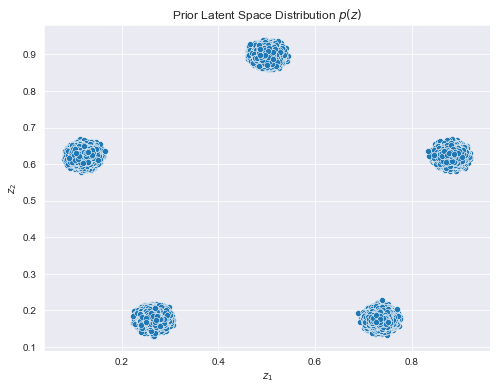

In [35]:
# init the plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# plot reconstruction error scatter plot
ax.scatter(z_continous_samples_all[:, 0], z_continous_samples_all[:, 1], c='C0', marker="o", edgecolors='w', linewidth=0.5) 
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

# add plot title
ax.set_title('Prior Latent Space Distribution $p(z)$');

Ok, great. Looks like anticipated.

## 4. Training the Adversarial Autoencoder Neural Network (AAE) Model

In this section, we will train our deep adversarial autoencoder neural network (as implemented in section 3. of the lab) using the encoded transactional data (created in section 2. of the lab) as well as the prior distribution (created in section 4. of the lab). More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.

### 4.1 Preparing the Network Training Data

Let's now start to train a corresponding model for **100 epochs** and a **mini-batch size of 128** journal entries per batch. This implies that the whole dataset will be fed to the AENN 5 times in chunks of 128 journal entries yielding to 4,165 mini-batches (533,009 journal entries / 128 journal entries per mini-batch) per epoch.

In [36]:
# specify training parameters
num_epochs = 10
mini_batch_size = 128

During the training phase, we will fetch the individual mini-batches of the entire population of journal entries. To achieve this, we will use PyTorch's `DataLoader` that provides single- or multi-process iterators over a given dataset to load one mini-batch at a time. By enabling `shuffle=True` the data will be reshuffled at every epoch prior to feeding it to the network. 

In [37]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# note: we set num_workers to zero to retrieve deterministic results

# determine if CUDA is available at compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

### 4.2 Running the Network Training

Finally, we start training the model. The training procedure of each mini-batch is performed in two phases, namely a (1) reconstruction phase and (2) regularization phase. The distinct training steps conducted during the reconstruction phase are the following:

>1. do a journal entry batch forward pass through the encoder-decoder networks,
>2. compute the combined reconstruction loss $\mathcal{L}_{\theta}^{REC}(x^{i};\hat{x}^{i})$, 
>3. do a backward pass through the encoder-decoder part, and,
>4. update the parameters of the encoder $q_\theta(\cdot)$ and decoder $p_\theta(\cdot)$ networks.

The distinct training steps conducted during the regularization phase are the following (discriminator training):

>1. do a journal entry batch forward pass through the generator network to obtain representation $z^{i}_{fake} \sim q_\theta(\cdot)$,
>2. sample representation from the imposed mixture of Gaussians prior distribution $z^{i}_{real} \sim p(\cdot)$,
>3. compute the discrimination loss $\mathcal{L}_{\theta}^{DIS}(z^{i}_{fake}; z^{i}_{real})$, and,
>4. update the parameters of the discriminator $d_\phi(\cdot)$ network.

The distinct training steps conducted during the regularization phase are the following (generator training):

>1. do a journal entry batch forward pass through the generator network to obtain representation $z^{i}_{fake} \sim q_\theta(\cdot)$,
>2. compute the generation loss $\mathcal{L}_{\theta}^{GEN}(z^{i}_{fake})$, and,
>3. update the parameters of the generator $q_\theta(\cdot)$ network.

To ensure learning while training our AENN model we will monitor whether the distinct losses decrease with progressing training. Therefore, we obtain and evaluate the reconstruction loss $\mathcal{L}_{\theta}^{REC}$, the discrimination loss $\mathcal{L}_{\theta}^{DIS}$, as well as, the generation loss $\mathcal{L}_{\theta}^{GEN}$ of the entire dataset after each training epoch. Based on this evaluation we conclude on the training progress and whether the loss is converging (indicating that the learned model might not improve any further).

In addition, after each training epoch we want to save a checkpoint for both the actual `encoder`, `decoder` and `discriminator` model. The saved model checkpoints contain a snapshot of the trained model parameter values upon completion of a training epoch. In general, it is good practice, to save checkpoints at regular intervals during training. In case your system crashes during training you are able continue from the last checkpoint rather than start over from scratch.

>- `torch.save()`: saves a checkpoint of the actual encoder and decoder model parameter values to disc.

Initialize the per epoch collected model losses:

In [38]:
# init collection of training losses
epoch_reconstruction_losses = []
epoch_discriminator_losses = []
epoch_generator_losses = []

Define the verbose step size of the adversarial autoencoder training process:

In [39]:
mini_batch_verbose_step = 1000

Let's now start the adversarial autoencoder network training:

In [40]:
# initialize training adversarial autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0
    
    # init epoch training losses
    batch_reconstruction_losses = 0.0
    batch_discriminator_losses = 0.0
    batch_generator_losses = 0.0

    # determine if GPU training is enabled
    if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

        # set all networks / models in GPU mode
        encoder_train.cuda()
        decoder_train.cuda()
        discriminator_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()
    discriminator_train.train()
    
    # start timer
    start_time = datetime.now()

    # iterate over epoch mini batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
          
            # convert mini batch to torch variable
            mini_batch_torch = torch.cuda.FloatTensor(mini_batch_data)

        else:
          
             # convert mini batch to torch variable
             mini_batch_torch = torch.FloatTensor(mini_batch_data)
        
        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        # =================== reconstruction phase =====================
        
        # run autoencoder encoding - decoding
        z_sample = encoder_train(mini_batch_torch)
        mini_batch_reconstruction = decoder_train(z_sample)

        # split input date to numerical and categorical part
        batch_cat = mini_batch_torch[:, :ori_dataset_categ_transformed.shape[1]]
        batch_num = mini_batch_torch[:, ori_dataset_categ_transformed.shape[1]:]
        
        # split reconstruction to numerical and categorical part
        rec_batch_cat = mini_batch_reconstruction[:, :ori_dataset_categ_transformed.shape[1]]
        rec_batch_num = mini_batch_reconstruction[:, ori_dataset_categ_transformed.shape[1]:]

        # backward pass + gradients update
        rec_error_cat = reconstruction_criterion_categorical(input=rec_batch_cat, target=batch_cat)  # one-hot attr error
        rec_error_num = reconstruction_criterion_numeric(input=rec_batch_num, target=batch_num)  # numeric attr error

        # combine both reconstruction errors
        reconstruction_loss = rec_error_cat + rec_error_num
        
        # run backward pass - determine gradients
        reconstruction_loss.backward()
        
        # collect batch reconstruction loss
        batch_reconstruction_losses += reconstruction_loss.item()
        
        # update network parameter - decoder and encoder
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== regularization phase =====================
        # =================== discriminator training ===================

        # set discriminator in evaluation mode
        discriminator_train.eval()

        # generate target latent space data
        z_target_batch = z_continous_samples_all[random.sample(range(0, z_continous_samples_all.shape[0]), mini_batch_size),:]

        # convert to torch tensor
        z_target_batch = torch.FloatTensor(z_target_batch)

        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
            z_target_batch = z_target_batch.cuda()

        # determine mini batch sample generated by the encoder -> fake gaussian sample
        z_fake_gauss = encoder_train(mini_batch_torch)

        # determine discriminator classification of both samples
        d_real_gauss = discriminator_train(z_target_batch) # real sampled gaussian 
        d_fake_gauss = discriminator_train(z_fake_gauss) # fake created gaussian

        # determine discriminator classification target variables
        d_real_gauss_target = torch.FloatTensor(torch.ones(d_real_gauss.shape)) # real -> 1
        d_fake_gauss_target = torch.FloatTensor(torch.zeros(d_fake_gauss.shape)) # fake -> 0

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

            # push tensors to CUDA
            d_real_gauss_target = d_real_gauss_target.cuda()
            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine individual discrimination losses
        discriminator_loss_real = discriminator_criterion(target=d_real_gauss_target, input=d_real_gauss) # real loss
        discriminator_loss_fake = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss) # fake loss
        
        # add real loss and fake loss
        discriminator_loss = discriminator_loss_fake + discriminator_loss_real

        # run backward through the discriminator network
        discriminator_loss.backward()
        
        # collect discriminator loss
        batch_discriminator_losses += discriminator_loss.item()

        # update network the discriminator network parameters
        discriminator_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        # =================== regularization phase =====================
        # =================== generator training =======================

        # set encoder / generator in training mode
        encoder_train.train()
        
        # reset the encoder / generator networks gradients
        encoder_train.zero_grad()

        # determine fake gaussian sample generated by the encoder / generator
        z_fake_gauss = encoder_train(mini_batch_torch)

        # determine discriminator classification of fake gaussian sample
        d_fake_gauss = discriminator_train(z_fake_gauss)

        # determine discriminator classification target variables
        d_fake_gauss_target = torch.FloatTensor(torch.ones(d_fake_gauss.shape)) # fake -> 1

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

            # push tensors to CUDA
            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine discrimination loss of fake gaussian sample
        generator_loss = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss)
        
        # collect generator loss
        batch_generator_losses += generator_loss.item()

        # run backward pass - determine gradients
        generator_loss.backward()

        # update network paramaters - encoder / generatorc
        encoder_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

    # collect epoch training losses - reconstruction loss
    epoch_reconstruction_loss = batch_reconstruction_losses / mini_batch_count
    epoch_reconstruction_losses.extend([epoch_reconstruction_loss])
    
    # collect epoch training losses - discriminator loss
    epoch_discriminator_loss = batch_discriminator_losses / mini_batch_count
    epoch_discriminator_losses.extend([epoch_discriminator_loss])
    
    # collect epoch training losses - generator loss
    epoch_generator_loss = batch_generator_losses / mini_batch_count
    epoch_generator_losses.extend([epoch_generator_loss])
    
    # print epoch reconstruction loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, reconstruction loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_reconstruction_loss))
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, discriminator loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_discriminator_loss))
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, generator loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_generator_loss))
    
    # =================== save model snapshots to disk ============================
    
    # save trained encoder model file to disk
    now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
    encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))
    
    # save trained discriminator model file to disk
    decoder_model_name = "{}_ep_{}_discriminator_model.pth".format(now, (epoch+1))
    torch.save(discriminator_train.state_dict(), os.path.join("./models", decoder_model_name))

[LOG TRAIN 20220508-13:33:39] epoch: 0001/0010, reconstruction loss: 0.0364
[LOG TRAIN 20220508-13:33:39] epoch: 0001/0010, discriminator loss: 1.4962
[LOG TRAIN 20220508-13:33:39] epoch: 0001/0010, generator loss: 0.6810
[LOG TRAIN 20220508-13:35:03] epoch: 0002/0010, reconstruction loss: 0.0225
[LOG TRAIN 20220508-13:35:03] epoch: 0002/0010, discriminator loss: 1.3857
[LOG TRAIN 20220508-13:35:03] epoch: 0002/0010, generator loss: 0.6947
[LOG TRAIN 20220508-13:36:27] epoch: 0003/0010, reconstruction loss: 0.0196
[LOG TRAIN 20220508-13:36:27] epoch: 0003/0010, discriminator loss: 1.3855
[LOG TRAIN 20220508-13:36:27] epoch: 0003/0010, generator loss: 0.6935
[LOG TRAIN 20220508-13:37:53] epoch: 0004/0010, reconstruction loss: 0.0181
[LOG TRAIN 20220508-13:37:53] epoch: 0004/0010, discriminator loss: 1.3854
[LOG TRAIN 20220508-13:37:53] epoch: 0004/0010, generator loss: 0.6937
[LOG TRAIN 20220508-13:39:17] epoch: 0005/0010, reconstruction loss: 0.0171
[LOG TRAIN 20220508-13:39:17] epoch:

Let's now evaluate the magnitude of the distinct losses with progressing training:

Text(0, 0.5, 'reconstruction loss')

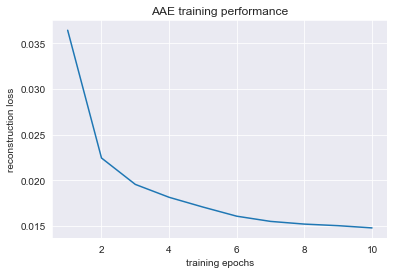

In [41]:
# plot the reconstruction loss per training epoch
plt.plot(range(1, len(epoch_reconstruction_losses)+1), epoch_reconstruction_losses)

# set plot title
plt.title('AAE training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('reconstruction loss')

Text(0, 0.5, 'discrimination loss')

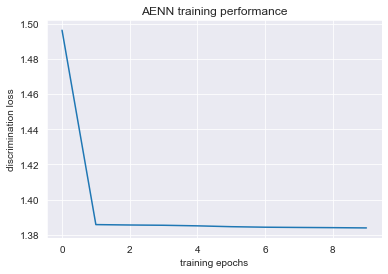

In [42]:
# plot the discriminator loss per training epoch
plt.plot(range(0, len(epoch_discriminator_losses)), epoch_discriminator_losses)

# set plot title
plt.title('AENN training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('discrimination loss')

Text(0, 0.5, 'generation loss')

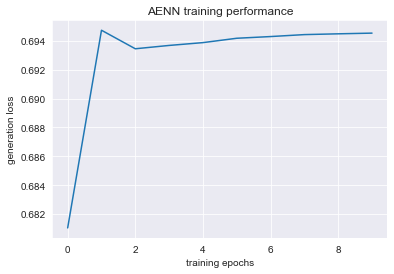

In [43]:
# plot the generator loss per training epoch
plt.plot(range(0, len(epoch_generator_losses)), epoch_generator_losses)

# set plot title
plt.title('AENN training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('generation loss')

How does the reconstruction loss change as we progress in training our model? After 5 epochs, we can observe that our reconstruction loss already went down significantly and starts to converge nicely. This indicates that our network did a pretty good job in learning the structure and attributes of the journal entries.

But, from the plot we also observe that the model could probably be trained a couple more epochs as the trend of the reconstruction error still decreases for the last few epochs. In order to save time, we will continue the lab using a pre-trained model already trained by 20 epochs.

## 5. Evaluating the Autoencoder Neural Network (AENN) Model

In order, to detect interpretable accounting anomalies in real-world ERP datasets we propose a novel anomaly score utilizing the introduced AAE architecture. The score builds on the regularisation applied throughout the AAE training process, namely the reconstruction error loss and the adversarial loss, described in the following.

As the training of such model is computationally expensive, within the scope of this notebook we provide the pretrained model (400 training epochs) that can be used to assess the proposed anomaly score.

In [44]:

# restore pretrained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/deepAD/master/models/20190818-03_22_18_ep_401_encoder_model.pth'
decoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/deepAD/master/models/20190818-03_22_18_ep_401_decoder_model.pth'

# Read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)
decoder_bytes = urllib.request.urlopen(decoder_model_name)

# Load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())
decoder_buffer = io.BytesIO(decoder_bytes.read())

# init training network classes / architectures
encoder_eval = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])
decoder_eval = Decoder(output_size=ori_subset_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    encoder_eval = encoder_eval.cuda()
    decoder_eval = decoder_eval.cuda()
    
# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer, map_location=torch.device('cpu')))
decoder_eval.load_state_dict(torch.load(decoder_buffer, map_location=torch.device('cpu')))

<All keys matched successfully>

Let's also specify a dataloader that provides the ability to evaluate the journal entrie in an "unshuffled" batch-wise manner:

In [45]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader_eval = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=0)

# determine if CUDA is available at the compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    
    # push dataloader to CUDA
    dataloader_eval = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=False)

### 5.1 Visualize the Latent Space Represenation

Perform the feed forward pass through the pretrained encoder model and collect learned representations of all journal entries.

In [46]:
# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:

    # determine latent space representation of all transactions
    z_enc_transactions_batch = encoder_eval(enc_transactions_batch)
    
    # case: initial batch 
    if batch_count == 0:

      # collect reconstruction errors of batch
      z_enc_transactions_all = z_enc_transactions_batch
      
    # case: non-initial batch
    else:
      
      # collect reconstruction errors of batch
      z_enc_transactions_all = torch.cat((z_enc_transactions_all, z_enc_transactions_batch), dim=0)
    
    # increase batch count
    batch_count += 1

# convert to numpy array
z_enc_transactions_all = z_enc_transactions_all.cpu().detach().numpy()

Let's visually inspect the learned latent space representation obtained of each journal entry $x^{i}$:

/var/folders/0c/kv1v2fb905ldnn4ct19ws9780000gn/T/ipykernel_32761/794566923.py:12: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="x", label='global', edgecolors='w', s=60) # plot global outliers
/var/folders/0c/kv1v2fb905ldnn4ct19ws9780000gn/T/ipykernel_32761/794566923.py:13: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C3', marker="x", label='local', edgecolors='w', s=60) # plot local outliers


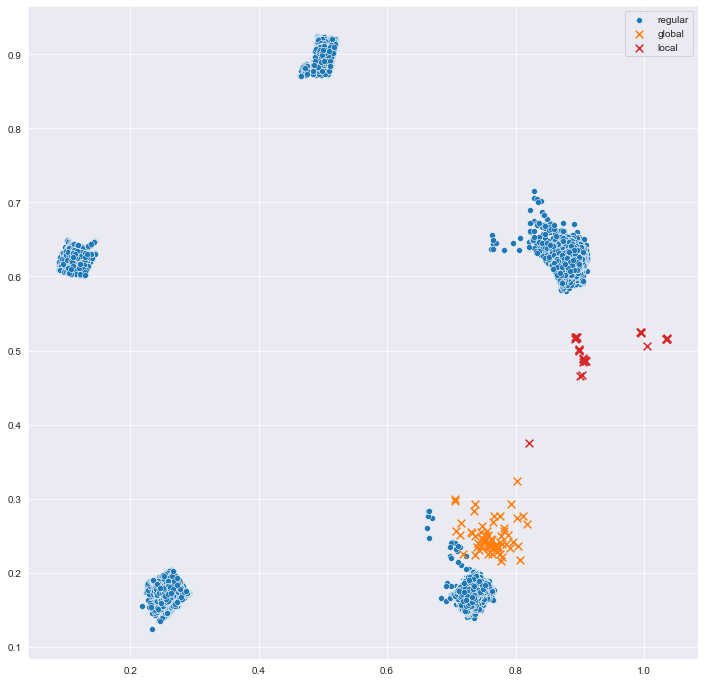

In [47]:
# prepare plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# obtain regular transactions as well as global and local anomalies
regular_data = z_enc_transactions_all[label == 'regular']
global_outliers = z_enc_transactions_all[label == 'global']
local_outliers = z_enc_transactions_all[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', marker="o", label='regular', edgecolors='w', linewidth=0.5) # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="x", label='global', edgecolors='w', s=60) # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C3', marker="x", label='local', edgecolors='w', s=60) # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best');

### 5.2 Determine Normalized Mode Divergence (MD) of Each Journal Entry

Journal entries that exhibit anomalous attribute values (global anomalies) result in an increased divergence from the imposed multi-modal prior, e.g., as in this work the divergence to the modes of an imposed mixture of multivariate isotropic Gaussians $\mathcal{N}(\mu,\mathcal{I})$, where $\mu \in \mathcal{R}^m$ defines the $\tau$ modes of the distinct Gaussians denoted by $\mu =\{\mu^1 \ldots \mu^\tau \}$. Throughout the AAE training, the entries will be "pushed" towards the high probability density regions of the prior by the regularization. In order to be able to discriminate between the imposed prior and the learned aggregated posterior the AAE aims to keep the majority of the entries within the high-density regions (modes) of the prior. In contrast, representations that correspond to rare or anomalous journal entries will tend to differ from the imposed modes and be placed in the priors low-density regions. We use this characteristic and obtain an entry's $x^{i}$ mode divergence $D$ as the Euclidean distance of the entry's learned representation $z^i$ to its closest mode $\mu^\tau$. Formally, we derive the mode divergence as denoted by $D_{\theta^*}^{\tau}(z^{i};\mu) = \min\limits_{\tau} \lVert z^i-\mu^\tau \rVert^2 $ under optimal model parameters $\theta^*$. Finally, we calculate the normalized mode divergence $MD$ as expressed by:

\begin{equation}
MD_{\theta^*}^{\tau}(x^{i}) = \frac{D_{\theta^*}^{\tau}(z^i;\mu) - D_{\theta^*, min}^{\tau}}{D_{\theta^*, max}^{\tau} - D_{\theta^*, min}^{\tau}},
\end{equation}

where $D_{min}$ and $D_{max}$ denotes the min- and max-values of the obtained mode divergences given by $D_{\theta^*}$ and closest mode $\tau$.

In [48]:
# define euclidean distance calculation
def compute_euclid_distance(x, y):
    
    # calculate euclidean distance 
    euclidean_distance = np.sqrt(np.sum((x - y) ** 2, axis=1))
    
    # return euclidean distance
    return euclidean_distance

Obtain the mode assignment and mode divergence of each journal entry $x^{i}$:

In [49]:

# determine distance to each mode
distances = np.apply_along_axis(func1d=compute_euclid_distance, axis=1, arr=z_enc_transactions_all, y=mu_gauss)

# determine mode divergence
mode_divergence = np.min(distances, axis=1)

# determine min-mode id
cluster_ids = np.argmin(distances, axis=1)

Normalize the obtained mode divergenes $D_{\theta^*}^{\tau}$ of each mode $\tau$:

In [70]:
# normalize the mode divergences of each mode

# prepare empty arrays of the same shape and dtype
mode_divergence_all_scaled = np.asarray(mode_divergence)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries mode divergence to the range [0,1]
    mode_divergence_all_scaled[mask] = (mode_divergence[mask] - mode_divergence[mask].min()) / (mode_divergence[mask].ptp())   

Let's visually inspect the obtained mode divergence obtained of each journal entry $x^{i}$:

/var/folders/0c/kv1v2fb905ldnn4ct19ws9780000gn/T/ipykernel_28847/1409545110.py:28: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[mode].scatter(global_outliers.index, global_outliers['mode_divergence'],
/var/folders/0c/kv1v2fb905ldnn4ct19ws9780000gn/T/ipykernel_28847/1409545110.py:31: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[mode].scatter(local_outliers.index, local_outliers['mode_divergence'],


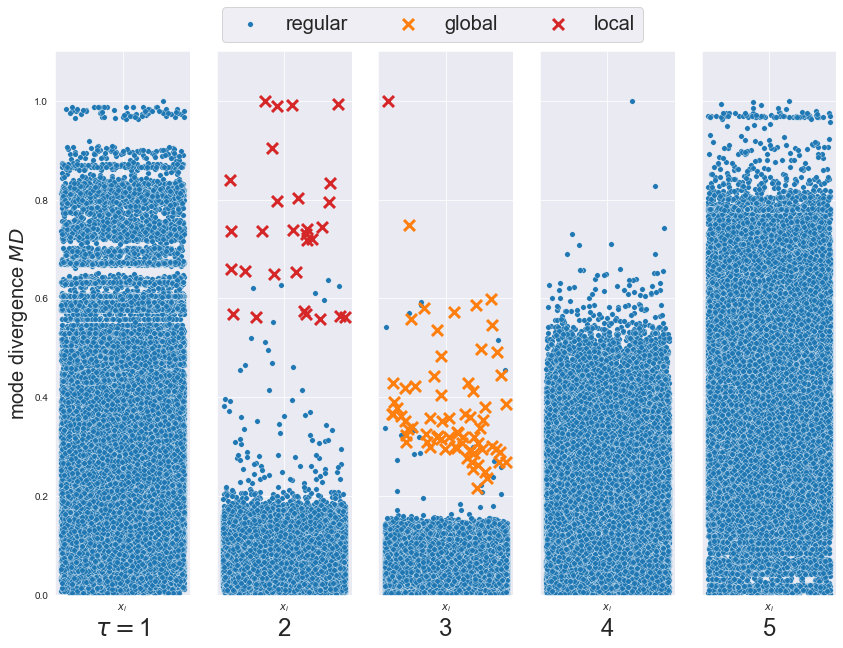

In [71]:

# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(mode_divergence_all_scaled, name='mode_divergence'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['mode_divergence'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['mode_divergence'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['mode_divergence'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('mode divergence $MD$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)

### 5.3 Determine Normalized Reconstruction Error (RE) of Each Journal Entry

Journal entries that exhibit anomalous attribute value co-occurrences (local anomalies) tend to result in an increased reconstruction error. This is caused by the compression capability of the AAE architecture. Anomalous and therefore unique attribute co-occurrences exhibit an increased probability of getting lost in the encoders "lossy" compression. As a result, their low dimensional representation will overlap with regular entries in the latent space and are not reconstructed correctly by the decoder. Formally, we obtain the reconstruction error $E$ of each entry $x^i$ and its reconstruction $\hat{x}^i$ as the squared-difference denoted by $E_{\theta^*}^{\tau}(x^{i};\hat{x}^{i}) = \frac{1}{k} \sum_{j=1}^{k}{(x^{i}_{j} - \hat{x}^{i}_{j})}^2$ under optimal model parameters $\theta^*$. Finally, we calculate the normalized reconstruction error $RE$ as expressed by:

\begin{equation}
RE_{\theta^*}^{\tau}(x^{i};\hat{x}^{i}) = \frac{E_{\theta^*}^{\tau}(x^i;\hat{x}^{i}) - E_{\theta^*, min}^{\tau}}{E_{\theta^*, max}^{\tau} - E_{\theta^*, min}^{\tau}},
\end{equation}

where $E_{min}$ and $E_{max}$ denotes the min- and max-values of the obtained reconstruction errors given by $E_{\theta^*}$ and closest mode $\tau$. Let's obtain the reconstruction error of each journal entry $x^{i}$:


In [ ]:
# define the optimization criterion / loss function
reconstruction_criterion_categorical_eval = nn.BCEWithLogitsLoss(reduction='none')
reconstruction_criterion_numeric_eval = nn.MSELoss(reduction='none')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical_eval = reconstruction_criterion_categorical_eval.cuda()
    reconstruction_criterion_numeric_eval = reconstruction_criterion_numeric_eval.cuda()

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:

    # determine latent space representation of all transactions
    z_enc_transactions_batch = encoder_eval(enc_transactions_batch)

    # reconstruct input samples
    reconstruction_batch = decoder_eval(z_enc_transactions_batch)

    # split input transactions into numeric and categorical parts
    input_cat_all = enc_transactions_batch[:, :ori_dataset_categ_transformed.shape[1]]
    input_num_all = enc_transactions_batch[:, ori_dataset_categ_transformed.shape[1]:]

    # split reconstruction into numeric and categorical parts
    rec_cat_all = reconstruction_batch[:, :ori_dataset_categ_transformed.shape[1]]
    rec_num_all = reconstruction_batch[:, ori_dataset_categ_transformed.shape[1]:]

    # compute rec error
    rec_error_cat_all = reconstruction_criterion_categorical_eval(input=rec_cat_all, target=input_cat_all).mean(dim=1)
    rec_error_num_all = reconstruction_criterion_numeric_eval(input=rec_num_all, target=input_num_all).mean(dim=1)

    # combine categorical and numerical errors
    rec_error_all_batch = rec_error_cat_all + rec_error_num_all
    
    # case: initial batch
    if batch_count == 0:
    
      # collect reconstruction errors of batch
      rec_error_all = rec_error_all_batch
    
    # case: non-initial batch
    else:
      
      # collect reconstruction errors of batch
      rec_error_all = torch.cat((rec_error_all, rec_error_all_batch), dim=0)
    
    # increase batch count
    batch_count += 1

# convert to numpy array
rec_error_all = rec_error_all.cpu().detach().numpy()

Normalize the obtained reconstruction errors $E_{\theta^*}^{\tau}$ of each mode $\tau$:

In [ ]:
# normalize the reconstruction errors of each mode

# prepare empty arrays of the same shape and dtype
rec_error_all_scaled = np.asarray(rec_error_all)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries reconstruction error to the range [0,1]
    rec_error_all_scaled[mask] = (rec_error_all[mask] - rec_error_all[mask].min()) / (rec_error_all[mask].ptp())

Let's visually inspect the reconstruction error obtained for each journal entry $x^{i}$:

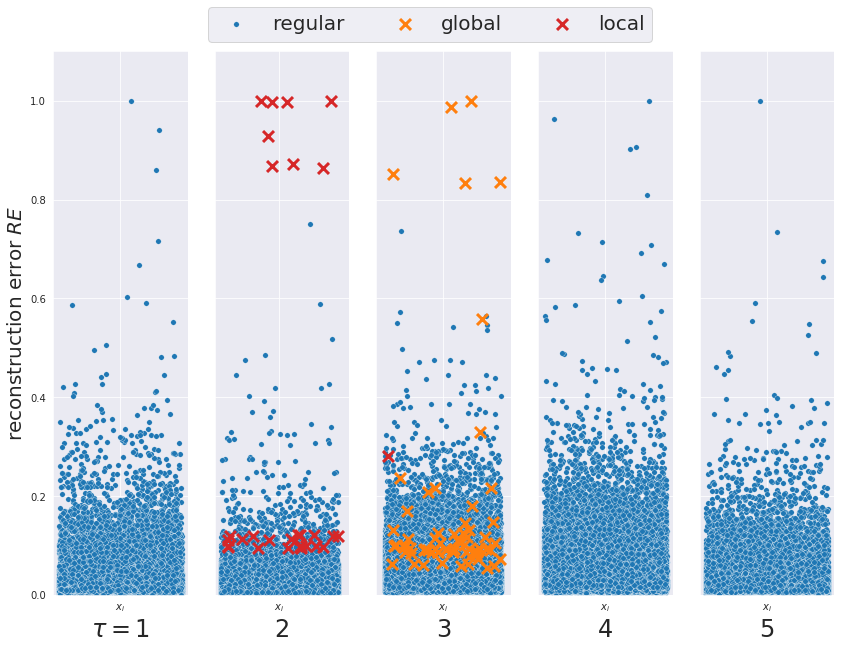

In [55]:

# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(rec_error_all_scaled, name='rec_error'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['rec_error'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['rec_error'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['rec_error'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('reconstruction error $RE$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)

### 5.3 Determine Anomaly Score $AS^{\tau}$ of Each Journal Entry

Quantifying both characteristics for a given journal entry, we can reasonably conclude (1) if the entry is anomalous and (2) if it was created by a "regular" business activity. To detect global and local accounting anomalies in real-world audit scenarios we propose to score each journal entry $x^i$ by its normalized reconstruction error $RE$ regularized and normalized mode divergence $MD$ given by:

\begin{equation}
AS^{\tau}(x^{i};\hat{x}^{i}) = \alpha \times RE_{\theta^*}^{\tau}(x^{i};\hat{x}^{i}) + (1-\alpha) \times MD_{\theta^*}^{\tau}(x^{i}),
\end{equation} 

for each individual journal entry $x^{i}$ and optimal model parameters $\theta^*$ and closest mode $\tau$. We introduce $\alpha$ as a factor to balance both characteristics.

In [ ]:
# set alpha 
alpha = 0.4

# determine journal entry anomaly score
anomaly_score = alpha * rec_error_all_scaled + (1.0 - alpha) * mode_divergence_all_scaled

### 5.4 Visual Inspection of the Obtained Anomaly Scores 

Let's visually inspect the obtained anomaly scores obtained for each journal entry:

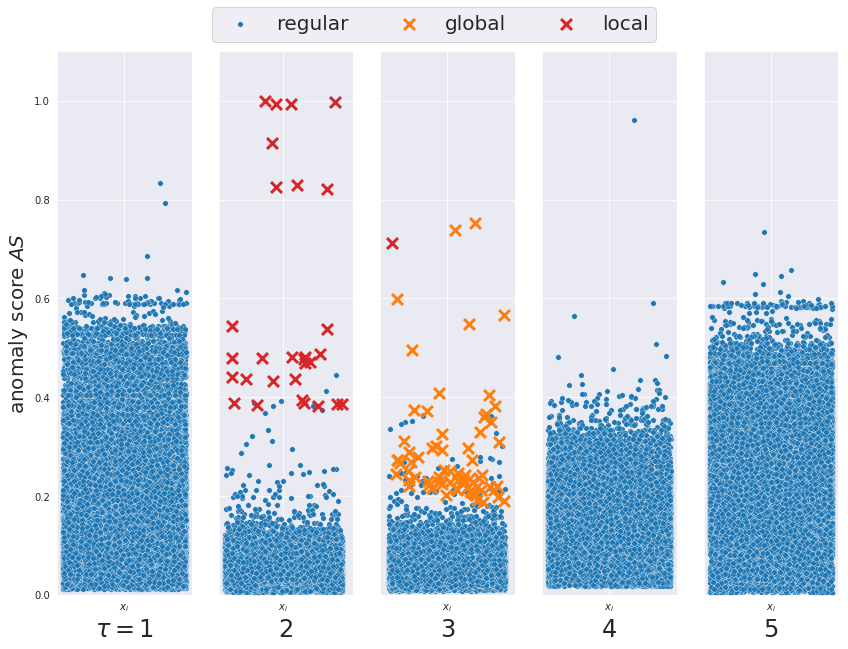

In [57]:

# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(anomaly_score, name='anomaly_score'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))

# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['anomaly_score'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['anomaly_score'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['anomaly_score'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('anomaly score $AS$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)

The visualization reveals that the pre-trained model is able to reconstruct the majority of regular journal entries, while failing to do so, for the anomalous ones. As a result, the model reconstruction error can be used to distinguish both "global" anomalies (orange) and "local" anomalies (green) from the regular journal entries (blue).

To further investigate our observation and confirm the initial assumption, let's have a closer look into the journal entries exhibiting an anomaly score >= 0.25 selected from the cluster mode $\tau=3$. We assume that these journal entries correspond to the "global" anomalies of the original dataset:

In [58]:
ori_dataset['label'] = label
ori_dataset['tau'] = cluster_ids

# inspect transactions exhibiting a reconstruction error >= 0.2
ori_dataset[(anomaly_score >= 0.25) & (cluster_ids == 2)]

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label,tau
6287,334152,C2,C22,C1,C19,A1,B1,4.758323e+05,1.000000e+00,regular,2
12939,532980,C1,C20,C1,C18,A1,B1,9.106583e+05,5.444984e+04,local,2
35691,532967,M07,S42,J81,A14,O49,Z01,9.244553e+07,5.958503e+07,global,2
35944,532917,J82,Q22,P32,Z74,Y19,K27,9.244553e+07,5.958504e+07,global,2
41925,532923,T17,R47,D84,F38,I81,D68,9.244552e+07,5.958505e+07,global,2
52048,532958,Q82,S54,J53,T46,Y42,S06,9.244553e+07,5.958503e+07,global,2
54975,529161,C4,C41,C1,C10,A2,B1,5.002054e+05,1.000000e+00,regular,2
68527,318707,C7,C77,C2,C27,A3,B3,7.904000e+01,5.310000e+03,regular,2
71036,532939,B00,O64,T41,Y68,H15,L79,9.244552e+07,5.958503e+07,global,2
75500,274782,C9,C94,C9,C91,A2,B1,1.002600e+02,3.068010e+05,regular,2


Let's now also have a closer look into the journal entries exhibiting anomaly score >= 0.4 selected from the cluster mode $\tau=2$. We assume that these journal entries mostly correspond to the "local" anomalies of the original dataset:

In [59]:
# inspect transactions exhibiting a anomaly_score >= 0.4 from the mode 2
ori_dataset[(anomaly_score >= 0.4) & (cluster_ids == 1)]

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label,tau
32317,532989,C1,C11,C1,C53,A1,B1,910653.005238,54439.211421,local,1
34058,532991,C1,C11,C1,C91,A1,B1,910668.887465,54440.856583,local,1
34059,533003,C1,C11,C1,C64,A1,B1,910631.632279,54443.283794,local,1
97954,532984,C1,C11,C1,C68,A1,B1,910648.636111,54442.618111,local,1
170320,533001,C1,C11,C1,C30,A1,B1,910645.965114,54452.809780,local,1
183064,533006,C1,C11,C1,C82,A1,B1,910648.873494,54436.705575,local,1
213105,532981,C1,C17,C1,C20,A1,B1,910664.385738,54436.897572,local,1
220927,533002,C1,C11,C1,C60,A1,B1,910648.545092,54446.382830,local,1
234335,532987,C1,C11,C1,C80,A1,B1,910647.596802,54446.113055,local,1
234460,532988,C1,C11,C1,C26,A1,B1,910655.728514,54441.600292,local,1


In [60]:
!jupyter nbconvert --to script KDD_2019.ipynb

[NbConvertApp] WARNING | pattern u'KDD_2019.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Run nbco

## References

Major elements of the lab content are inspired by the publication "Detection of Anomalies in Large Scale Accounting Data using Deep Autoencoder Networks", of M. Schreyer, T. Sattarov, D. S. Borth, A. Dengel, and B. Reimer, 2017 (arXiv preprint available under: https://arxiv.org/abs/1709.05254).

[1] ACFE, "Report to the Nations on Occupational Fraud and Abuse", The 2016 Global Fraud Study, Association of Certified Fraud Examiners (ACFE), 2016.

[2] J. T. Wells, "Corporate Fraud Handbook: Prevention and Detection", John Wiley & Sons, 2017.

[3] PwC, "Pulling Fraud Out of the Shadows", The Global Economic Crime and Fraud Survey 2018, PricewaterhouseCoopers LLP, 2018.

[4] S. Markovitch, P. Willmott, "Accelerating the digitization of business processes", McKinsey & Company (2014) 1–5.

[5] SAP, SAP Global Corporate Affairs, Corporate Factsheet 2017, 2017.

[6] E. A. Lopez-Rojas , A. Elmir, and S. Axelsson, "PaySim: A financial mobile money simulator for fraud detection", In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus, 2016.

[7] G. E. Hinton, and R. R. Salakhutdinov, "Reducing the dimensionality of data with neural networks", science 313, no. 5786: 504-507, 2006.

[8] N. Srivastava, G. E. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, "Dropout: A simple way to prevent neural networks from overfitting", The Journal of Machine Learning Research, 15(1), 1929-1958, 2014.

[9] X. Glorot and Y. Bengio, "Understanding the difficulty of training deep feedforward neural networks", Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS), 9:249–256, 2010.

[10] B. Xu, N. Wang, T. Chen, and M. Li, "Empirical Evaluation of Rectified Activations in Convolution Network", ICML Deep Learning Workshop, pages 1–5, 2015.

[11] D. P. Kingma and J. Ba, "Adam: A method for stochastic optimization", International Conference on Learning Representations (ICLR). 2015.

[12] G. E. Hinton, N. Srivastava, A. Krizhevsky, I. Sutskever, R. R. Salakhutdinov. "Improving neural networks by preventing co-adaptation of feature detectors", Technical Report, 2012.

[13] D. P. Kingma, M. Welling. "Auto-encoding variational bayes", arXiv preprint arXiv:1312.6114, 2013.

[14] Makhzani, A., Shlens, J., Jaitly, N., Goodfellow, I., & Frey, B., "Adversarial autoencoders", arXiv preprint arXiv:1511.05644, 2015.
